# CNN for MNIST Dataset

### With PyTorch and Skorch

MNIST is one of the simplest datasets to start with: 28x28 black and white images with digits from 0 to 9. Here we use it to understand, step by step, how a CNN works and how to train it with Skorch (a scikit-learn-style wrapper).

**What we will do:**
- Load and normalize MNIST
- Separate into Train and Valid (with a seed for reproducibility)
- Define a simple CNN
- Train with Skorch and view metrics across epochs
- Evaluate in a test environment and generate a report and confusion matrix

##Libraries & Dependencies

We import PyTorch, torchvision (MNIST) and skorch.

In [1]:
%%capture

!pip install skorch
!pip install torchinfo


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchinfo import summary

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, EpochScoring
from skorch.helper import predefined_split
from skorch.dataset import ValidSplit

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("PyTorch version:", torch.__version__)

PyTorch version: 2.9.0+cpu


## Device Configuration
We use GPU if available; if not, CPU.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Variable Configuration
We fixed a seed so that the results would be reproducible.

In [4]:
SEED_VALUE = 73
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

MNIST_MEAN = 0.1307
MNIST_STD = 0.3081
TRAIN_SIZE = 50000
VAL_SIZE = 10000
BATCH_SIZE = 64
SAMPLE = 16


## Data Management, Transform and Tensor generation

We create the transform (tensor + normalization), load the dataset and perform the split.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MNIST_MEAN, std=MNIST_STD)
])

dataset = datasets.MNIST(root = './data', train = True, transform = transform, download=True)
test_data = datasets.MNIST(root="./data", train = False, transform=transform, download=True)
classes = dataset.classes

gen = torch.Generator().manual_seed(SEED_VALUE)
train_data, val_data = random_split(dataset, [TRAIN_SIZE, VAL_SIZE], generator=gen)

train_labels = dataset.targets[train_data.indices]
val_labels   = dataset.targets[val_data.indices]

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.31MB/s]


## Quick look of train label distribution

We check if the train data are balanced

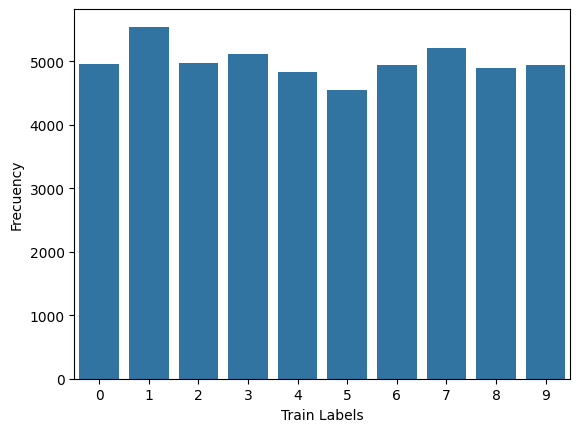

In [6]:
sns.countplot(x=train_labels)
plt.xlabel("Train Labels")
plt.ylabel("Frecuency")
plt.show()

## Display image samples

We show a sample of 16 images from the train dataset.

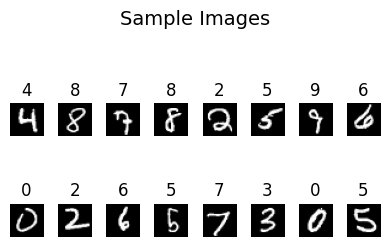

In [7]:
plt.figure(figsize=(4, 3))
for i in range(SAMPLE):
  img, label = train_data[i]
  img = img.permute(1, 2, 0)
  plt.subplot(2, SAMPLE//2, i + 1)
  plt.imshow(img, cmap='gray')
  plt.title(label)
  plt.axis("off")

plt.suptitle("Sample Images", fontsize=14)
plt.tight_layout()
plt.show()


### CNN PyTorch Implementation


We define a simple CNN model with 2 conv blocks and fully-connected layers.

In [8]:
class MNIST_Simple_Model(nn.Module):
    def __init__(self):
        super(MNIST_Simple_Model, self).__init__()

        self.Block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.Block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.Block1(x)
        x = self.Block2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Summary MNIST Model
We check the dimensions and number of parameters.

In [9]:
simple_model = MNIST_Simple_Model()

simple_model.to(device)

summary(simple_model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MNIST_Simple_Model                       [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          832
│    └─BatchNorm2d: 2-2                  [64, 32, 28, 28]          64
│    └─ReLU: 2-3                         [64, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [64, 32, 14, 14]          --
├─Sequential: 1-2                        [64, 64, 7, 7]            --
│    └─Conv2d: 2-5                       [64, 64, 14, 14]          51,264
│    └─BatchNorm2d: 2-6                  [64, 64, 14, 14]          128
│    └─ReLU: 2-7                         [64, 64, 14, 14]          --
│    └─MaxPool2d: 2-8                    [64, 64, 7, 7]            --
├─Flatten: 1-3                           [64, 3136]                --
├─Dropout: 1-4                           [64, 3136]                --
├─Linear:

## Model weight initialization

We initialize the Conv and Linear weights to train in a stable way.

In [10]:
def init_weights(module):
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.3)
    elif isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_normal_(module.weight)
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.3)

## Skorch Wrapper
Skorch takes our PyTorch model and turns it into an API that allows us to perform fit, predict, and score in a practical way.

In [11]:
# Learning
learning = LRScheduler(
    policy=torch.optim.lr_scheduler.StepLR,
    step_size=3,
    gamma=0.1
)

# Accuracy
training_acc = EpochScoring(
    scoring='accuracy',
    on_train=True,
    name='train_acc',
    lower_is_better=False
)

validation_acc = EpochScoring(
    scoring='accuracy',
    on_train=False,
    name='valid_acc',
    lower_is_better=False
)

# Skorch Wrapper
simple_model_wrapper = NeuralNetClassifier(
    module=MNIST_Simple_Model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=0.001,
    max_epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=[learning, training_acc, validation_acc],
    device=device,
    train_split=predefined_split(val_data),  # ValidSplit(0.1667, stratified=True),
    classes=classes
)

# Model Skorch Initialización
simple_model_wrapper.initialize()
simple_model_wrapper.module_.apply(init_weights)


MNIST_Simple_Model(
  (Block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Training

## Train the model
We train for a few epochs and monitor the training/valid metrics.

In [12]:
simple_model_wrapper.fit(train_data, y=None)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_acc    train_loss    valid_acc    valid_loss      lr       dur
-------  -----------  ------------  -----------  ------------  ------  --------
      1       0.9584        0.1329       0.9821        0.0591  0.0010  135.3983
      2       0.9832        0.0527       0.9868        0.0441  0.0010  117.3472
      3       0.9874        0.0385       0.9866        0.0451  0.0010  119.4505
      4       0.9940        0.0178       0.9920        0.0288  0.0001  123.2566
      5       0.9956        0.0144       0.9928        0.0281  0.0001  116.7974
      6       0.9959        0.0127       0.9925        0.0273  0.0001  120.0797
      7       0.9971        0.0097       0.9925        0.0272  0.0000  123.8962
      8       0.9969        0.0104       0.9922        0.0274  0.0000  116.5655
      9       0.9969        0.0099       0.9920        0.0272  0.0000  117.5743
     10       0.9971        0.0091       0

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MNIST_Simple_Model(
    (Block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dropout): Dropout(p=0.3, inplace=False)
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  ),
)

# Training history with Skorch
After training the model, we save the history (accuracy and loss).

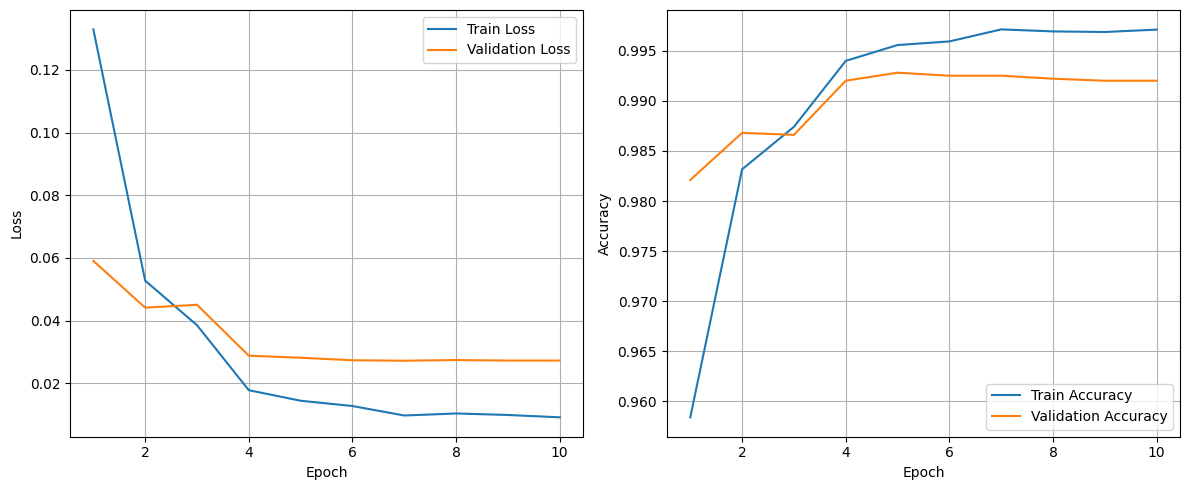

In [13]:
# Get history object
history = simple_model_wrapper.history

# Extract values over epochs
epochs = [row['epoch'] for row in history]
train_loss = [row['train_loss'] for row in history]
valid_loss = [row['valid_loss'] for row in history]
train_acc = [row['train_acc'] for row in history]
valid_acc = [row['valid_acc'] for row in history]

# Plot Loss vs Epoch
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Test Accuracy
Now we evaluate the test set.

In [14]:
test_labels_pred = simple_model_wrapper.predict(test_data)

test_labels_true = test_data.targets.numpy()

print('Test accuracy:', (test_labels_pred == test_labels_true).mean())

Test accuracy: 0.9934


## Example of a single-digit prediction
We choose a single-digit image and see what the model predicts.

Real Label: 7
Prediction: 7


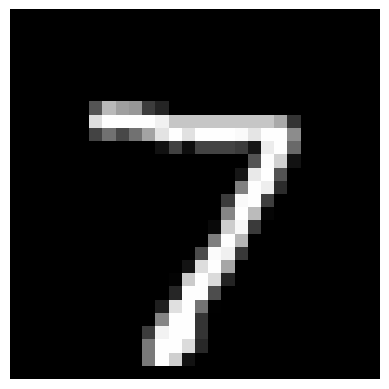

In [15]:
digit, digit_label = test_data[0]
digit = digit.unsqueeze(0)
digit_label_pred = simple_model_wrapper.predict(digit)[0]

print("Real Label:", digit_label)
print("Prediction:", digit_label_pred)

plt.imshow(digit.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

#Classification Report

This report shows how well the model predicts each digit individually in test data

In [17]:
print(classification_report(test_labels_true, test_labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



#Confusion Matrix

The confusion matrix helps us see where the model makes mistakes and which digits are confused with each other.

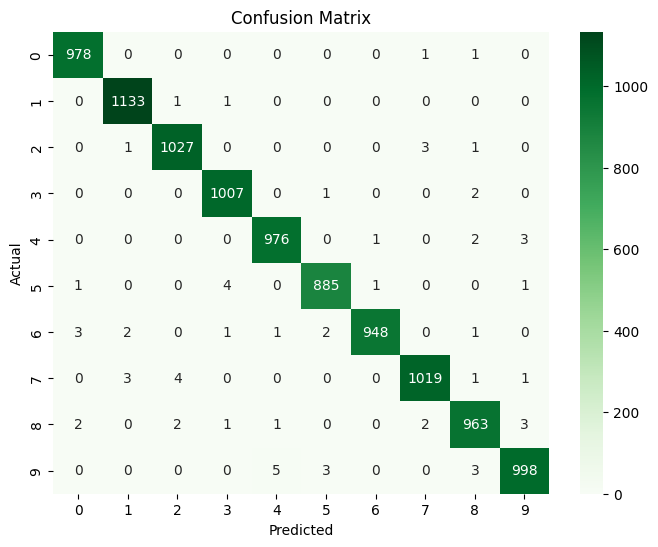

In [19]:
test_labels_pred = np.array(test_labels_pred)
conf_matrix = confusion_matrix(test_labels_true, test_labels_pred)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Quick Conclusions

- MNIST is a good starting point for understanding CNNs.

- If train_acc and valid_acc increase and valid_loss decreases, the model is learning.

- When valid_acc plateaus, it is usually no longer worthwhile to continue training.

- The confusion matrix shows you which digits are confused most frequently.